In [1]:
#载入所有需要使用的包
import torch
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import cv2
from skimage import morphology
from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F
import torch
from PIL import Image, ImageOps
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from datetime import datetime
from torchvision.transforms.functional import to_tensor, to_pil_image

In [2]:
def create_dataframe(fg_dir: str, alpha_dir: str) -> pd.DataFrame:
    # Set the base path for the dataset
    

    # Set the FG and Alpha directories based on the provided parameters
    fg_path =  Path(fg_dir)
    alpha_path = Path(alpha_dir)

    # Re-list the FG and Alpha images in case there was an issue with the initial listing
    fg_images = list(fg_path.rglob("*.*"))
    alpha_images = list(alpha_path.rglob("*.*"))

    # Initialize lists for holding the matched file paths
    fg_file_paths = []
    alpha_file_paths = []

    # Map of alpha files for quick lookup by name
    alpha_files_map = {alpha_image.name: alpha_image for alpha_image in alpha_images}

    # Iterate over FG images and find corresponding Alpha images by name
    for fg_image_path in fg_images:
        file_name = fg_image_path.name
        if file_name in alpha_files_map:
            # If the corresponding Alpha file is found, add both paths to the lists
            fg_file_paths.append(str(fg_image_path))
            alpha_file_paths.append(str(alpha_files_map[file_name]))

    # Create the DataFrame directly from the lists of file paths
    df_files_corrected = pd.DataFrame({
        "FG": fg_file_paths,
        "Alpha": alpha_file_paths
    })

    return df_files_corrected

In [3]:
def group_images_by_size(annotations_df):
    # 创建一个字典来存储不同尺寸的图片路径
    size_to_paths = {}

    # 遍历DataFrame中的每一行
    for index, row in annotations_df.iterrows():
        img_path = row.iloc[0]  # 第一列是原图文件的位置
        # 获取图片尺寸
        with Image.open(img_path) as img:
            size = img.size

        # 将具有相同尺寸的图片路径分组
        if size not in size_to_paths:
            size_to_paths[size] = [index]
        else:
            size_to_paths[size].append(index)

    # 根据分组创建新的DataFrame列表
    grouped_annotations_files = []
    for indices in size_to_paths.values():
        grouped_df = annotations_df.iloc[indices]
        grouped_annotations_files.append(grouped_df)

    # 统计各个尺寸的图像数量
    size_counts = {size: len(indices) for size, indices in size_to_paths.items()}

    # 绘制柱形图
    fig, ax = plt.subplots(figsize=(10, 6))
    sizes = list(size_counts.keys())
    counts = list(size_counts.values())
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    ax.bar(range(len(sizes)), counts, color=bar_colors[:len(sizes)])
    ax.set_xticks(range(len(sizes)))
    ax.set_xticklabels([f"{size[0]}x{size[1]}" for size in sizes], rotation=45, ha='right')
    ax.set_xlabel('Image Size')
    ax.set_ylabel('Count')
    ax.set_title('Image Size Distribution')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.show()

    return grouped_annotations_files

In [4]:
class OriginModNetDataLoader(Dataset):
    def __init__(self, annotations_file, resize_dim=None, transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.resize_dim = resize_dim

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_labels.iloc[idx, 0]
            mask_path = self.img_labels.iloc[idx, 1]
            img = self._load_image(img_path)
            mask = self._load_mask(mask_path)

            if self.transform:
                img = self.transform(img)
                trimap = self.get_trimap(mask)
                mask = self.transform(mask)

            if self.resize_dim is not None:
                img = self._center_crop_and_resize(img)
                mask = self._center_crop_and_resize(mask)
                trimap = self._center_crop_and_resize(trimap, trimap=True)
            else:
                img = self._resize(img)
                mask = self._resize(mask)
                trimap = self._resize(trimap, trimap=True)

            img = torch.squeeze(img, 0)
            mask = torch.squeeze(mask, 0)
            trimap = torch.squeeze(trimap, 1)

            return img.cuda(), trimap.cuda(), mask.cuda()
        except Exception as e:
            print(f"Error processing image at index {idx}: {str(e)}")
            return None

    def _load_image(self, img_path):
        img = np.asarray(Image.open(img_path))
        if len(img.shape) == 2:
            img = img[:, :, None]
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)
        elif img.shape[2] == 4:
            img = img[:, :, 0:3]
        return Image.fromarray(img)

    def _load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        return Image.fromarray(mask)

    def get_trimap(self, alpha, dilation_radius=10):
        fg = np.array(np.equal(alpha, 255).astype(np.float32))
        unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
        unknown = unknown - fg
        unknown = distance_transform_edt(unknown == 0) <= dilation_radius
        trimap = fg + unknown * 0.5
        return torch.unsqueeze(torch.from_numpy(trimap), dim=0)

    
    def _resize(self, img, trimap=False):
        im = img[None, :, :, :]
        ref_size = self.resize_dim

        im_b, im_c, im_h, im_w = im.shape
        if im_h > 1024 or im_w > 1024:
            scale_factor = 0.5
        else:
            scale_factor = min(ref_size / max(im_h, im_w), ref_size / min(im_h, im_w))

        im_rh = int(im_h * scale_factor)
        im_rw = int(im_w * scale_factor)

        im_rh = im_rh + (32 - im_rh % 32) if im_rh % 32 != 0 else im_rh
        im_rw = im_rw + (32 - im_rw % 32) if im_rw % 32 != 0 else im_rw

        if trimap:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='nearest')
        else:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

        return im
    
    def _center_crop_and_resize(self, img, trimap=False):
        # 确保 img 有一个批次维度
        img = img[None, :, :, :]
    
        original_height, original_width = img.shape[2], img.shape[3]
        target_height, target_width = self.resize_dim

        # 计算缩放比例，确保缩放后的图像至少有一边等于或大于目标尺寸
        scale_width = target_width / original_width
        scale_height = target_height / original_height
        scale = max(scale_width, scale_height)
    
        new_height, new_width = int(round(original_height * scale)), int(round(original_width * scale))

        # 使用 F.interpolate 对图像进行缩放
        im = F.interpolate(img, size=(new_height, new_width), mode='bilinear' if not trimap else 'nearest')

        # 计算中心裁剪坐标，确保裁剪后尺寸为目标尺寸
        y1 = max(0, (new_height - target_height) // 2)
        x1 = max(0, (new_width - target_width) // 2)

        y2 = y1 + target_height
        x2 = x1 + target_width

    # 检查并调整裁剪尺寸，防止由于向下取整导致的尺寸缺失
        if y2 > new_height:
            y1 -= y2 - new_height
        if x2 > new_width:
            x1 -= x2 - new_width

        # 进行中心裁剪
        im = im[:, :, y1:y1+target_height, x1:x1+target_width]

    # 假设最终只处理一个图像，可以选择移除批次维度
    
        return im



In [5]:
class ImageMatteLoader:
    def __init__(self, annotations_file):
        self.annotations_file = annotations_file
    
    def __len__(self):
        return len(self.annotations_file)
    
    def __getitem__(self, idx):
        img_path = self.annotations_file.iloc[idx, 0]
        matte_path = self.annotations_file.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        matte = Image.open(matte_path).convert("L")
        return image, matte, matte
    
    def show(self, idx, dimsize=None):
        image, matte, _ = self.__getitem__(idx)

        if dimsize is not None:
            if isinstance(dimsize, (list, tuple)) and len(dimsize) == 2:
                # dimsize 为数组时，进行裁剪和缩放
                image = self._resize_and_crop(image, dimsize)
                matte = self._resize_and_crop(matte, dimsize)
            elif isinstance(dimsize, int):
                # dimsize 为数字时，按照宽度进行缩放
                scale_factor = dimsize / image.width
                new_height = int(image.height * scale_factor)
                image = image.resize((dimsize, new_height), Image.Resampling.LANCZOS)
                matte = matte.resize((dimsize, new_height), Image.Resampling.LANCZOS)


        # 合并图像进行展示
        combined = self._combined_display(image, matte)
        combined.show()
    
    def _resize_and_crop(self, image, target_size):
        img_tensor = to_tensor(image)[None, :, :, :]
        target_height, target_width = target_size

        _, _, original_height, original_width = img_tensor.shape
        scale = max(target_height / original_height, target_width / original_width)
        new_height, new_width = int(original_height * scale), int(original_width * scale)

        img_tensor = F.interpolate(img_tensor, size=(new_height, new_width), mode='bilinear', align_corners=False)

        y1 = max(0, new_height - target_height) // 2
        x1 = max(0, new_width - target_width) // 2
        img_tensor = img_tensor[:, :, y1:y1+target_height, x1:x1+target_width]

        return to_pil_image(img_tensor.squeeze(0))

    def _combined_display(self, image, matte):
        image = np.asarray(image)
        matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
        foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

        combined = np.concatenate((image, foreground, matte * 255), axis=1)
        return Image.fromarray(np.uint8(combined))
    
    
    def evaluate(self, indices=None):
        if indices is None:
            indices = range(len(self.annotations_file))
        
        sad_scores = []
        grad_scores = []
        conn_scores = []
        fg_scores = []
        bg_scores = []
        msd_scores = []
        mae_scores = []
        psnr_scores = []
        
        for idx in indices:
            image, pred_matte, true_matte = self[idx]
            
            # 将预测的matte和真实matte转换为numpy数组
            pred_matte_np = np.array(pred_matte) / 255.0
            true_matte_np = np.array(true_matte) / 255.0
            
            # 计算SAD
            sad = np.abs(pred_matte_np - true_matte_np).mean()
            sad_scores.append(sad)
            
            # 计算GRAD
            pred_grad_x = np.abs(np.gradient(pred_matte_np, axis=1)).mean()
            pred_grad_y = np.abs(np.gradient(pred_matte_np, axis=0)).mean()
            true_grad_x = np.abs(np.gradient(true_matte_np, axis=1)).mean()
            true_grad_y = np.abs(np.gradient(true_matte_np, axis=0)).mean()
            grad = (np.abs(pred_grad_x - true_grad_x) + np.abs(pred_grad_y - true_grad_y)) / 2
            grad_scores.append(grad)
            
            # 计算CONN
            conn = 1 - structural_similarity(pred_matte_np, true_matte_np, data_range=1, multichannel=False)
            conn_scores.append(conn)
            
            # 计算FG
            fg_mask = true_matte_np > 0.5
            fg_score = np.abs(pred_matte_np[fg_mask] - true_matte_np[fg_mask]).mean()
            fg_scores.append(fg_score)
            
            # 计算BG
            bg_mask = true_matte_np <= 0.5
            bg_score = np.abs(pred_matte_np[bg_mask] - true_matte_np[bg_mask]).mean()
            bg_scores.append(bg_score)
            
            # 计算MSD
            msd = np.square(pred_matte_np - true_matte_np).mean()
            msd_scores.append(msd)
            
            # 计算MAE
            mae = np.abs(pred_matte_np - true_matte_np).mean()
            mae_scores.append(mae)
            
            # 计算PSNR
            psnr = peak_signal_noise_ratio(true_matte_np, pred_matte_np, data_range=1)
            psnr_scores.append(psnr)
        
        # 计算平均得分
        avg_sad = np.mean(sad_scores)
        avg_grad = np.mean(grad_scores)
        avg_conn = np.mean(conn_scores)
        avg_fg = np.mean(fg_scores)
        avg_bg = np.mean(bg_scores)
        avg_msd = np.mean(msd_scores)
        avg_mae = np.mean(mae_scores)
        avg_psnr = np.mean(psnr_scores)
        
        return {
            'SAD': avg_sad,
            'GRAD': avg_grad,
            'CONN': avg_conn,
            'FG': avg_fg,
            'BG': avg_bg,
            'MSD': avg_msd,
            'MAE': avg_mae,
            'PSNR': avg_psnr
        }



In [6]:
class ModNetImageGenerator(ImageMatteLoader):
    
    def __init__(self,  annotations_file ,modnet, ckpt_path=None, device='cuda',transform=None):
        super().__init__(annotations_file)
        self.modnet = modnet
        self.device = device
        self.transform = transform
        if ckpt_path is not None and os.path.exists(ckpt_path):
            self.load_weights(ckpt_path)
        
        self.modnet.to(device)
        self.modnet.eval()
        
        self.ref_size = 512
        self.im_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
    
    def load_weights(self, ckpt_path):
        if self.device == 'cuda' and torch.cuda.is_available():
            weights = torch.load(ckpt_path)
        else:
            weights = torch.load(ckpt_path, map_location=torch.device('cpu'))
        self.modnet.load_state_dict(weights)
    
    def preprocess(self, im):
        im = np.asarray(im)
        if len(im.shape) == 2:
            im = im[:, :, None]
        if im.shape[2] == 1:
            im = np.repeat(im, 3, axis=2)
        elif im.shape[2] == 4:
            im = im[:, :, 0:3]
    
        im = Image.fromarray(im)
    
        # 调整图像尺寸使其符合模型要求
        original_size = im.size
        #print(im.size)
        adjusted_size = [((dim + 31) // 32) * 32 for dim in original_size]  # 使尺寸成为32的倍数
        im = im.resize(adjusted_size, Image.Resampling.LANCZOS)
    
        im = self.im_transform(im)
        im = im[None, :, :, :]
        ###!!!!!型号不对
        original_size = (original_size[1], original_size[0])
    
        return im, original_size
    
    def predict(self, im):
        im, original_size = self.preprocess(im)
    
        with torch.no_grad():
            _, _, matte = self.modnet(im.to(self.device), True)
    
        matte = F.interpolate(matte, size=original_size, mode='area')
        matte = matte[0][0].data.cpu().numpy()

    # 将matte转换为图像并返回
        matte_img = Image.fromarray((matte * 255).astype('uint8'), mode='L')
    
        return matte_img
    
    def __getitem__(self, idx):
        image, true_matte,_ = super().__getitem__(idx)
        pred_matte = self.predict(image)
        
        return image, pred_matte, true_matte
    


In [7]:
def train_modnet(data, model, model_name="MODNet", model_save_path="./model.pth", batch_size=4, \
                 learning_rate=0.01, epochs=40, step_size=0.25, gamma=0.1, update_freq=100, checkpoint_freq=5, \
                 checkpoint_dir='checkpoints', load_or_not=True):
    train_dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    modnet = model  # torch.nn.DataParallel(model).cuda()
    optimizer = torch.optim.SGD(modnet.parameters(), lr=learning_rate, momentum=0.9)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(step_size * epochs), gamma=gamma)
    model_config = "_lr_{}_bs_{}".format(learning_rate, batch_size)# + datetime.now().strftime('%m_%d_%H_%M')

    writer = SummaryWriter('runs/' + model_name + model_config)

    start_epoch = 0
    
    # 仅当load_or_not为真且检查点目录存在时，尝试从检查点恢复
    if load_or_not and os.path.exists(checkpoint_dir):
        checkpoint_files = os.listdir(checkpoint_dir)
        if checkpoint_files:
            latest_checkpoint = max(checkpoint_files, key=lambda cp: os.path.getmtime(os.path.join(checkpoint_dir, cp)))
            checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
            checkpoint = torch.load(checkpoint_path)
            modnet.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Loaded checkpoint from {checkpoint_path}. Starting from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
            # Assume supervised_training_iter is a function defined elsewhere
            semantic_loss, detail_loss, matte_loss = supervised_training_iter(modnet, optimizer, image, trimap, gt_matte)
            
            writer.add_scalar('semantic_loss', semantic_loss, epoch * len(train_dataloader) + idx)
            writer.add_scalar('detail_loss', detail_loss, epoch * len(train_dataloader) + idx)
            writer.add_scalar('matte_loss', matte_loss, epoch * len(train_dataloader) + idx)
        
        lr_scheduler.step()
        
        # 定期保存检查点
        if (epoch + 1) % checkpoint_freq == 0:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': modnet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict()
            }, checkpoint_path)
            print(f"Saved checkpoint to {checkpoint_path}")
    
    torch.save(modnet.state_dict(), model_save_path)


In [8]:
def process_image(image_path, model, ckpt_path):
    # 确保图像路径存在
    if not os.path.exists(image_path):
        print('Image path does not exist:', image_path)
        return None

    # 加载模型权重
    if torch.cuda.is_available():
        model = model.cuda()
        weights = torch.load(ckpt_path)
    else:
        weights = torch.load(ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(weights)
    model.eval()

    # 定义图像到张量的转换
    im_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 读取和预处理图像
    im = Image.open(image_path)
    im = np.asarray(im)
    if len(im.shape) == 2:
        im = im[:, :, None]
    if im.shape[2] == 1:
        im = np.repeat(im, 3, axis=2)
    elif im.shape[2] == 4:
        im = im[:, :, 0:3]
    im = Image.fromarray(im)
    im = im_transform(im)
    im = im[None, :, :, :]

    # 调整图像尺寸以满足模型输入要求
    ref_size = 512
    im_b, im_c, im_h, im_w = im.shape
    im_max = max(im_h, im_w)
    im_min = min(im_h, im_w)
    if im_max < ref_size or im_min > ref_size:
        scale = ref_size / float(im_min)
        if im_w >= im_h:
            im_rh = ref_size
            im_rw = int(im_w * scale)
        else:
            im_rw = ref_size
            im_rh = int(im_h * scale)
    else:
        im_rh = im_h
        im_rw = im_w
    im_rw -= im_rw % 32
    im_rh -= im_rh % 32
    im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

    # 进行预测
    with torch.no_grad():
        _, _, matte = model(im.cuda() if torch.cuda.is_available() else im,True)

    # 调整matte到原始图像尺寸
    matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
    matte = matte[0][0].data.cpu().numpy()

    # 将matte转换为图像并返回
    matte_img = Image.fromarray((matte * 255).astype('uint8'), mode='L')
    return im, matte_img

# 注意：你需要根据需要替换MODNet模型的实际定义
# from src.models.modnet import MODNet
# model = MODNet(backbone_pretrained=False)
# image_path = 'path/to/your/image.jpg'
# ckpt_path = 'path/to/your/model/weights.pth'
# image, matte = process_image(image_path, model, ckpt_path)
def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined


In [9]:
def init_model(model, ckpt_path=None):
    # 使用 DataParallel 包装模型并确保其在 GPU 上运行（如果可用）
    model = torch.nn.DataParallel(model).cuda()

    # 仅当检查点路径存在时尝试加载权重
    if ckpt_path is not None and os.path.exists(ckpt_path):
        if torch.cuda.is_available():
            weights = torch.load(ckpt_path)
        else:
            # 如果 CUDA 不可用，将权重映射到 CPU
            weights = torch.load(ckpt_path, map_location=torch.device('cpu'))
        
        model.load_state_dict(weights)

    # 将模型设置为评估模式
    model.eval()
    return model



In [10]:
base_path = "/mnt/data/Train/"
fg = base_path+"FG"
matte= base_path+"Alpha"
files = create_dataframe(fg,matte)

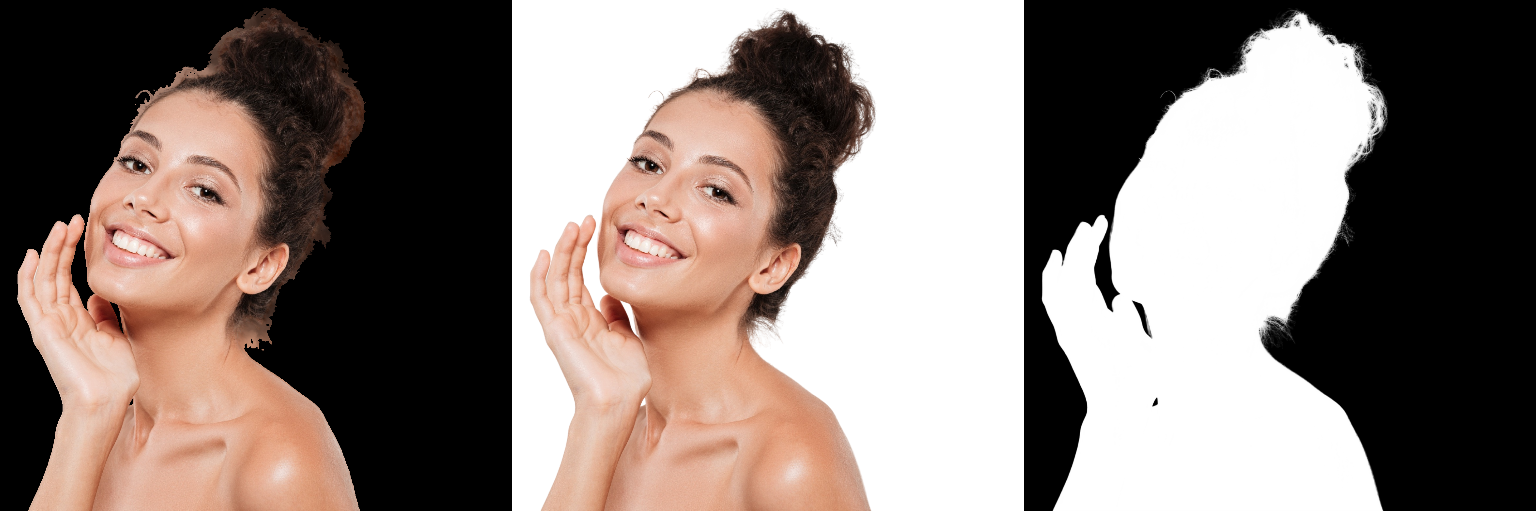

In [11]:
data = ImageMatteLoader(files)
data.show(100,[512,512])

In [12]:
transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)
            )
        ]
    )
#train_data = OriginModNetDataLoader(filter_data[0],transform=transformer)
#train_modnet(train_data,MODNet())

In [13]:
all_data = OriginModNetDataLoader(files,[512,512],transform=transformer)

In [14]:
#[[all_data[i][0].size(),all_data[i][1].size() ,all_data[i][2].size() ] for i in range(1,20)]
#[all_data[i][0].size()  for i in range(1,20)]

In [15]:
aim_model = init_model(MODNet(),ckpt_path="pretrained/modnet_photographic_portrait_matting.ckpt")
bad_model = init_model(MODNet())

In [ ]:
train_modnet(all_data,bad_model,epochs=100,batch_size=16)

Loaded checkpoint from checkpoints/checkpoint_40.pth. Starting from epoch 40
Saved checkpoint to checkpoints/checkpoint_45.pth
Saved checkpoint to checkpoints/checkpoint_50.pth
Saved checkpoint to checkpoints/checkpoint_55.pth
Saved checkpoint to checkpoints/checkpoint_60.pth
Saved checkpoint to checkpoints/checkpoint_65.pth
Saved checkpoint to checkpoints/checkpoint_70.pth
Saved checkpoint to checkpoints/checkpoint_75.pth
Saved checkpoint to checkpoints/checkpoint_80.pth
Saved checkpoint to checkpoints/checkpoint_85.pth


In [ ]:
test = ModNetImageGenerator(files,bad_model)
aim = ModNetImageGenerator(files,aim_model)
org = ImageMatteLoader(files)

In [ ]:
test.show(1)

In [ ]:
test.evaluate([1,2,3,4,5])

In [ ]:
aim.evaluate([1,2,3,4,5])